# Use Ragas to evaluate the OpenAI Assistant

**Please note that this test requires a large amount of OpenAI api token consumption. Please read it carefully and Pay attention to the number of times you request access.**

## 1. Prepare environment and data

Before starting, you must set OPENAI_API_KEY in your environment variables.

Install pip dependencies

In [3]:
! python -m pip install openai beir pandas ragas==0.0.17

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.4/227.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.5/807.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.2/219.2 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

Download [Financial Opinion Mining and Question Answering (fiqa) Dataset](https://sites.google.com/view/fiqa/) data if it not exists in your local space. We convert it into a ragas form that is easier to process, referring from this [script](https://github.com/explodinggradients/ragas/blob/main/experiments/baselines/fiqa/dataset-exploration-and-baseline.ipynb).

In [4]:
import json
import pandas as pd
from tqdm import tqdm
from datasets import Dataset
from beir import util
import os

def prepare_fiqa_without_answer(knowledge_path):
    dataset_name = "fiqa"

    if not os.path.exists(os.path.join(knowledge_path, f'{dataset_name}.zip')):
        url = (
            "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(
                dataset_name
            )
        )
        util.download_and_unzip(url, knowledge_path)

    data_path = os.path.join(knowledge_path, 'fiqa')
    with open(os.path.join(data_path, "corpus.jsonl")) as f:
        cs = [pd.Series(json.loads(l)) for l in f.readlines()]

    corpus_df = pd.DataFrame(cs)

    corpus_df = corpus_df.rename(columns={"_id": "corpus-id", "text": "ground_truth"})
    corpus_df = corpus_df.drop(columns=["title", "metadata"])
    corpus_df["corpus-id"] = corpus_df["corpus-id"].astype(int)
    corpus_df.head()

    with open(os.path.join(data_path, "queries.jsonl")) as f:
        qs = [pd.Series(json.loads(l)) for l in f.readlines()]

    queries_df = pd.DataFrame(qs)
    queries_df = queries_df.rename(columns={"_id": "query-id", "text": "question"})
    queries_df = queries_df.drop(columns=["metadata"])
    queries_df["query-id"] = queries_df["query-id"].astype(int)
    queries_df.head()

    splits = ["dev", "test", "train"]
    split_df = {}
    for s in splits:
        split_df[s] = pd.read_csv(os.path.join(data_path, f"qrels/{s}.tsv"), sep="\t").drop(
            columns=["score"]
        )

    final_split_df = {}
    for split in split_df:
        df = queries_df.merge(split_df[split], on="query-id")
        df = df.merge(corpus_df, on="corpus-id")
        df = df.drop(columns=["corpus-id"])
        grouped = df.groupby("query-id").apply(
            lambda x: pd.Series(
                {
                    "question": x["question"].sample().values[0],
                    "ground_truths": x["ground_truth"].tolist(),
                }
            )
        )

        grouped = grouped.reset_index()
        grouped = grouped.drop(columns="query-id")
        final_split_df[split] = grouped

    return final_split_df


knowledge_datas_path = './knowledge_datas'
fiqa_path = os.path.join(knowledge_datas_path, 'fiqa_doc.txt')

if not os.path.exists(knowledge_datas_path):
    os.mkdir(knowledge_datas_path)
contexts_list = []
answer_list = []

final_split_df = prepare_fiqa_without_answer(knowledge_datas_path)

docs = []

split = 'test'
for ds in final_split_df[split]["ground_truths"]:
    docs.extend([d for d in ds])
print(len(docs))

docs_str = '\n'.join(docs)
with open(fiqa_path, 'w') as f:
    f.write(docs_str)

split = 'test'
question_list = final_split_df[split]["question"].to_list()
ground_truth_list = final_split_df[split]["ground_truths"].to_list()

./knowledge_datas/fiqa.zip:   0%|          | 0.00/17.1M [00:00<?, ?iB/s]

1706


Now we have the question list and the ground truth list. And the knowledge documents are prepared in `fiqa_path`.


## 2. Building RAG using OpenAI assistant

To get the context content from the annotations returned by Open AI.

In [8]:
import time
from openai import OpenAI

client = OpenAI()

# Set OPENAI_API_KEY in your environment value

class OpenAITimeoutException(Exception):
    pass


def get_content_from_retrieved_message(message):
    # Extract the message content
    message_content = message.content[0].text
    annotations = message_content.annotations
    contexts = []
    for annotation in annotations:
        message_content.value = message_content.value.replace(annotation.text, f'')
        if (file_citation := getattr(annotation, 'file_citation', None)):
            contexts.append(file_citation.quote)
    if len(contexts) == 0:
        contexts = ['empty context.']
    return message_content.value, contexts


def try_get_answer_contexts(assistant_id, question, timeout_seconds=120):
    thread = client.beta.threads.create(
        messages=[
            {
                "role": "user",
                "content": question,
            }
        ]
    )
    thread_id = thread.id
    run = client.beta.threads.runs.create(
        thread_id=thread_id,
        assistant_id=assistant_id,
    )
    start_time = time.time()
    while True:
        elapsed_time = time.time() - start_time
        if elapsed_time > timeout_seconds:
            raise Exception("OpenAI retrieving answer Timeout！")

        run = client.beta.threads.runs.retrieve(
            thread_id=thread_id,
            run_id=run.id
        )
        if run.status == 'completed':
            break
    messages = client.beta.threads.messages.list(
        thread_id=thread_id
    )
    assert len(messages.data) > 1
    res, contexts = get_content_from_retrieved_message(messages.data[0])
    response = client.beta.threads.delete(thread_id)
    assert response.deleted is True
    return contexts, res


def get_answer_contexts_from_assistant(question, assistant_id, timeout_seconds=120, retry_num=6):
    res = 'failed. please retry.'
    contexts = ['failed. please retry.']
    try:
        for _ in range(retry_num):
            try:
                contexts, res = try_get_answer_contexts(assistant_id, question, timeout_seconds)
                break
            except OpenAITimeoutException as e:
                print('OpenAI retrieving answer Timeout, retry...')
                continue
    except Exception as e:
        print(e)
    return res, contexts

Build assistant and upload knowledge files.

In [11]:
file = client.files.create(
    file=open(fiqa_path, "rb"),
    purpose='assistants'
)

# Add the file to the assistant
assistant = client.beta.assistants.create(
    instructions="You are a customer support chatbot. You must use your retrieval tool to retrieve relevant knowledge to best respond to customer queries.",
    model="gpt-4-1106-preview",
    tools=[{"type": "retrieval"}],
    file_ids=[file.id]
)

## 3. Start Ragas Evaluation

Note that a large amount of OpenAI api token is consumed. Every time you ask a question and every evaluation, you will ask the OpenAI service. Please pay attention to your token consumption. If you only want to run a small number of tests, you can modify the code to reduce the test size.

In [13]:
for question in tqdm(question_list[:10]):
    answer, contexts = get_answer_contexts_from_assistant(question, assistant.id)
    answer_list.append(answer)
    contexts_list.append(contexts)

print(answer_list)

100%|██████████| 10/10 [03:58<00:00, 23.81s/it]

["To deposit a cheque issued to an associate of your business into your business account, you can follow one of the two methods described below:\n\n1. Endorsement by the Associate: Have the associate sign the back of the cheque. This is known as endorsing a third-party cheque, and it is a perfectly legal process. After endorsement, you can deposit the cheque into your business account. Note that there might be a longer hold period for the cheque to clear, especially if it's a large amount or if you don't have a well-established relationship with the bank. To reduce complications, you can have the associate go to the bank and endorse the cheque in front of a teller while providing identification, even if you are not present yourself.\n\n2. Deposit and Transfer by the Associate: Alternatively, the associate could deposit the cheque into their own account and then write a cheque to the business. This way, once the funds have cleared in the associate's account, they can easily transfer the

You can choose the indicators you care about to test.


In [14]:
from ragas import evaluate
from ragas.metrics import answer_relevancy, faithfulness, context_recall, context_precision, answer_similarity

ds = Dataset.from_dict({"question": question_list[:5],
                        # "contexts": contexts_list[:5],
                        "answer": answer_list[:5],
                        "ground_truths": ground_truth_list[:5]})

result = evaluate(
    ds,
    metrics=[
        # context_precision,
        # context_recall,
        # faithfulness,
        answer_relevancy,
        answer_similarity,
        # answer_correctness,
    ],

)
openai_output = result

evaluating with [answer_relevancy]


100%|██████████| 1/1 [00:04<00:00,  4.93s/it]


evaluating with [answer_similarity]


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


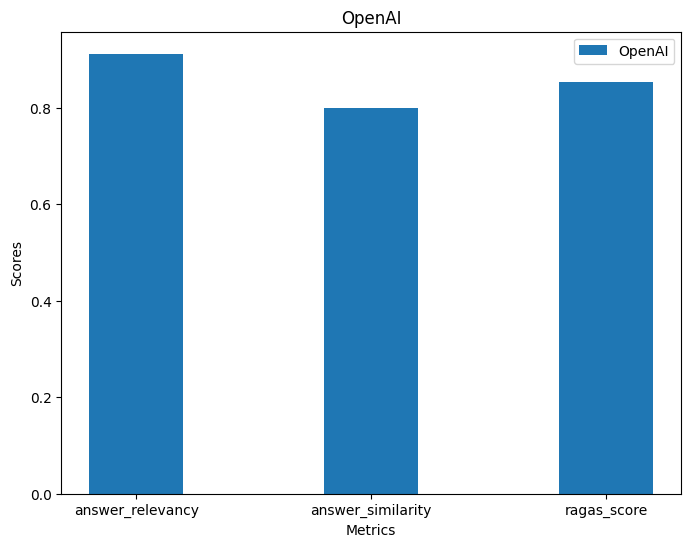

In [15]:
import matplotlib.pyplot as plt

# Extract keys and values from both dictionaries
keys = openai_output.keys()
openai_values = openai_output.values()
# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(keys, openai_values, width=0.4, align='center', label='OpenAI')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('OpenAI')import matplotlib.pyplot as plt

# Extract keys and values from both dictionaries
keys = openai_output.keys()
openai_values = openai_output.values()
# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(keys, openai_values, width=0.4, align='center', label='OpenAI')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('OpenAI')
plt.legend()
plt.show()

plt.legend()
plt.show()


#  CustomGPT

In [12]:
!pip install customgpt_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.0/507.0 kB 5.5 MB/s eta 0:00:00


In [15]:
from customgpt_client import CustomGPT
from customgpt_client.types import File
import uuid
CustomGPT.api_key = os.environ.get('CUSTOMGPT_API_KEY')

def get_customgpt_rag_response(question, project):
    prompt = question
    conversation_id = uuid.uuid4()
    max_retries = 3
    run_count = 0

    while run_count < max_retries:
        try:
            response = CustomGPT.Conversation.send(project_id=project.id, session_id=conversation_id, prompt=prompt)
            if response.status_code == 200:
                openai_response = response.parsed.data.openai_response
            else:
                raise Exception(f"Failed in generating CustomGPT Response::{response.status_code}")
            return openai_response
        except Exception as e:
            run_count += 1
            time.sleep(2)


def setup_project():
    file_ids = []
    project = CustomGPT.Project.create(project_name="Rag Evaluation")
    if project.status_code == 201:
        project_id = project.parsed.data.id
        source = CustomGPT.Source.create(project_id=project_id, file=File(payload=open(fiqa_path, "rb"), file_name=f"Fiqa"))

        is_chat_active = 0
        # Check to make sure at least one page is indexed
        while not is_chat_active:
            response_project = CustomGPT.Project.get(project_id=project_id)
            json_project = response_project.parsed
            is_chat_active = json_project.data.is_chat_active
            time.sleep(5)

        return project.parsed.data
    else:
        raise Exception("CustomGPT Project Creation Failed")
    pass

project = setup_project()


In [18]:
for question in tqdm(question_list):
    answer = get_customgpt_rag_response(question, project)
    answer_list.append(answer)
print(answer_list)

10


In [19]:
from ragas import evaluate
from ragas.metrics import answer_relevancy, faithfulness, context_recall, context_precision, answer_similarity

ds = Dataset.from_dict({"question": question_list[:10],
                        # "contexts": contexts_list,
                        "answer": answer_list,
                        "ground_truths": ground_truth_list[:10]})

result = evaluate(
    ds,
    metrics=[
        # context_precision,
        # context_recall,
        # faithfulness,
        answer_relevancy,
        answer_similarity,
        # answer_correctness,
    ],

)
customgpt_output = result

evaluating with [answer_relevancy]


100%|██████████| 1/1 [00:11<00:00, 11.78s/it]


evaluating with [answer_similarity]


100%|██████████| 1/1 [00:06<00:00,  6.65s/it]


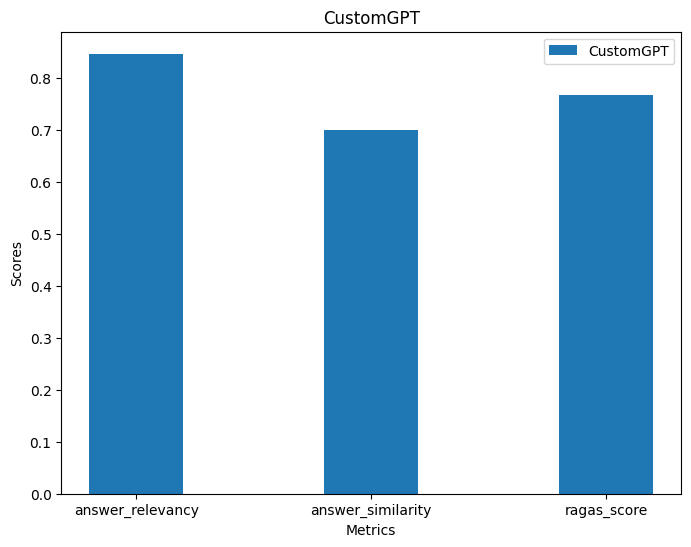

In [20]:
import matplotlib.pyplot as plt

# Extract keys and values from both dictionaries
keys = customgpt_output.keys()
customgpt_values = customgpt_output.values()
# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(keys, customgpt_values, width=0.4, align='center', label='CustomGPT')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('CustomGPT')
plt.legend()
plt.show()


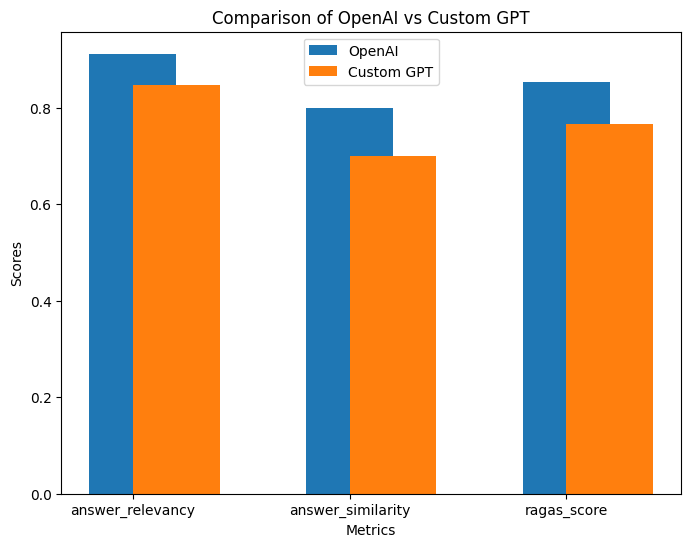

In [21]:
import matplotlib.pyplot as plt

# Data for openai
openai_data = openai_output

# Data for custom GPT
custom_gpt_data = customgpt_output

# Extract keys and values from both dictionaries
keys = openai_data.keys()
openai_values = openai_data.values()
custom_gpt_values = custom_gpt_data.values()

# Plot the data
plt.figure(figsize=(8, 6))
plt.bar(keys, openai_values, width=0.4, align='center', label='OpenAI')
plt.bar(keys, custom_gpt_values, width=0.4, align='edge', label='Custom GPT')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of OpenAI vs Custom GPT')
plt.legend()
plt.show()